In [1]:
import pandas as pd
from pathlib import Path
# import reframed
# from reframed import fluxes2escher
import cobra
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import hdbscan
import seaborn as sns

# Three tasks to do to choose gene knockouts
1. Do all gene knockouts using momentiJO1366 and se which set of pFBA fluxes that are least correlated to wt
2. Do all gene knockouts using momentiJO1366 and se which which set of shadow prices that are least correlated to wt
3. Use the data from Uwe Sauer's paper https://doi.org/10.15252%2Fmsb.20167150 to check that the identified gienes actually has an impact on metabolite levels


## 1 and 2

In [268]:
# Load ecoli model
# model = reframed.load_cbmodel('../models/e_coli/momentiJO1366.xml')
model = cobra.io.read_sbml_model('../models/e_coli/iJO1366.xml')
# model_ez = cobra.io.read_sbml_model('../models/e_coli/momentiJO1366.xml')
# model = cobra.io.read_sbml_model('../models/e_coli/iJR904.xml')
# model_ez.solver = 'gurobi'
model.solver = 'gurobi'
model.genes.get_by_id('b4301').knock_out()

In [269]:
# model.reactions.EX_glc__D_e.lower_bound = -10
model.reactions.EX_gal_e.lower_bound = -10

In [270]:
modeli = cobra.io.read_sbml_model('../models/e_coli/iJO1366.xml')
modeli.solver = 'gurobi'

In [271]:
g = modeli.genes[0]

In [272]:
genes = [g.id for g in model.genes]
essential_genes = []
pfba_sol_wt = cobra.flux_analysis.pfba(model)
sol_wt = model.optimize()
wt_growth = sol_wt.objective_value
for gene in genes:
    with model:
        g = model.genes.get_by_id(gene)
        g.knock_out()
        sol = model.slim_optimize()
        if sol < wt_growth*0.1:
            essential_genes.append(gene)
    

In [273]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.01024,0,0.00%
cl_e,EX_cl_e,0.01024,0,0.00%
cobalt2_e,EX_cobalt2_e,4.919E-05,0,0.00%
cu2_e,EX_cu2_e,0.001395,0,0.00%
fe2_e,EX_fe2_e,0.0316,0,0.00%
gal_e,EX_gal_e,10,6,50.00%
glc__D_e,EX_glc__D_e,10,6,50.00%
k_e,EX_k_e,0.384,0,0.00%
mg2_e,EX_mg2_e,0.01707,0,0.00%
mn2_e,EX_mn2_e,0.00136,0,0.00%


In [274]:
non_essential_genes = [g for g in genes if not g in essential_genes]

In [275]:
data = []
fluxes_dict = {}
shadow_price_dict = {}
fluxes_dict['WT'] = sol_wt.fluxes
for gene in non_essential_genes:
    with model:
        model.genes.get_by_id(gene).knock_out()
        sol = model.optimize()
        try:
            pfba_sol = cobra.flux_analysis.pfba(model)
        except:
            continue

        # Correlations between fluxes
        flux_pcorr, flux_ppval  = st.pearsonr(pfba_sol.fluxes, pfba_sol_wt.fluxes)
        flux_scorr, flux_spval  = st.spearmanr(pfba_sol.fluxes, pfba_sol_wt.fluxes)

        # Correlations between shadow prices
        sp_pcorr, sp_ppval  = st.pearsonr(pfba_sol.shadow_prices, pfba_sol_wt.shadow_prices)
        sp_scorr, sp_spval  = st.spearmanr(pfba_sol.shadow_prices, pfba_sol_wt.shadow_prices)
        data.append([gene, sol.objective_value, flux_pcorr, flux_ppval, flux_scorr, flux_spval, sp_pcorr, sp_ppval, sp_scorr, sp_spval])
        fluxes_dict[gene] = pfba_sol.fluxes
        shadow_price_dict[gene] = sol.shadow_prices

In [276]:
shadow_price_dict['WT'] = sol_wt.shadow_prices

In [277]:
df = pd.DataFrame(data, columns=['Gene','Growth rate', 'Flux pearson correlation', 'Flux pearson p-value', 'Flux spearman correlation', 'Flux spearman p-value',
                                        'Shadow price pearson correlation', 'Shadow price pearson p-value', 'Shadow price spearman correlation', 'Shadow price spearman p-value'])

In [278]:
gene_name_dict = {g.id:g.name for g in modeli.genes}
gene_name_dict['WT'] = 'Wild-type'

In [279]:
df['Gene name'] = df.Gene.map(gene_name_dict)

In [280]:
df.loc[df['Gene name'] == 'pgi',:]

,Gene,Growth rate,Flux pearson correlation,Flux pearson p-value,Flux spearman correlation,Flux spearman p-value,Shadow price pearson correlation,Shadow price pearson p-value,Shadow price spearman correlation,Shadow price spearman p-value,Gene name
985,b4025,1.953581,0.994759,0.0,0.980413,0.0,0.87928,0.0,0.916908,0.0,pgi


In [281]:
df['Normalized growth rate'] = df['Growth rate']/wt_growth

In [282]:
df.sort_values('Flux pearson correlation').head(20)

,Gene,Growth rate,Flux pearson correlation,Flux pearson p-value,Flux spearman correlation,Flux spearman p-value,Shadow price pearson correlation,Shadow price pearson p-value,Shadow price spearman correlation,Shadow price spearman p-value,Gene name,Normalized growth rate
37,b3732,0.839359,0.429847,1.175114e-116,0.917524,0.0,0.800213,0.0,0.887422,0.0,atpD,0.426625
44,b3736,0.839359,0.429847,1.175114e-116,0.917524,0.0,0.800213,0.0,0.887422,0.0,atpF,0.426625
43,b3731,0.839359,0.429847,1.175114e-116,0.917524,0.0,0.800213,0.0,0.887422,0.0,atpC,0.426625
41,b3738,0.839359,0.429847,1.175114e-116,0.917524,0.0,0.800213,0.0,0.887422,0.0,atpB,0.426625
38,b3737,0.839359,0.429847,1.175114e-116,0.917524,0.0,0.800213,0.0,0.887422,0.0,atpE,0.426625
39,b3733,0.839359,0.429847,1.175114e-116,0.917524,0.0,0.800213,0.0,0.887422,0.0,atpG,0.426625
40,b3734,0.839359,0.429847,1.175114e-116,0.917524,0.0,0.800213,0.0,0.887422,0.0,atpA,0.426625
32,b3735,0.839359,0.429847,1.175114e-116,0.917524,0.0,0.800213,0.0,0.887422,0.0,atpH,0.426625
291,b0432,1.790427,0.901739,0.000000e+00,0.990161,0.0,0.944444,0.0,0.951473,0.0,cyoA,0.910029
290,b0430,1.790427,0.901739,0.000000e+00,0.990161,0.0,0.944444,0.0,0.951473,0.0,cyoC,0.910029


In [283]:
# norm=plt.Normalize(, df['Normalized growth rate'].max())

Text(0.5, 0, 'Flux pearson correlation')

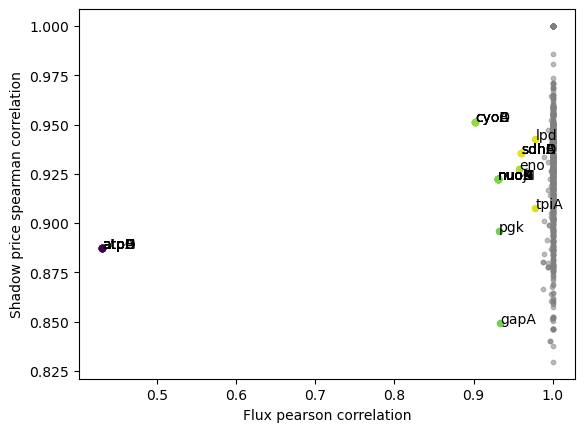

In [284]:
fig, ax = plt.subplots(1)
kind1 = 'pearson'
kind2 = 'spearman'

for i, row in df.iterrows():
    x = row[f'Flux {kind1} correlation']
    y = row[f'Shadow price {kind2} correlation']
    if (x < 0.98) and (y):
        ax.scatter(x,y, c = row['Normalized growth rate'], vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'Shadow price {kind2} correlation')
plt.xlabel(f'Flux {kind1} correlation')
# plt.ylim(0.5, 0.7)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

Text(0.5, 0, 'Flux pearson correlation')

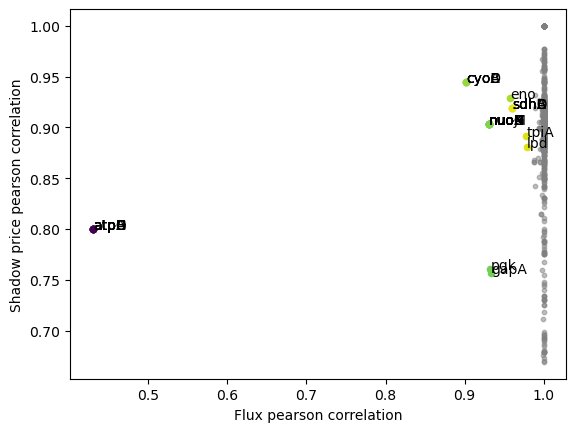

In [285]:
fig, ax = plt.subplots(1)
kind = 'pearson'
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    y = row[f'Shadow price {kind} correlation']
    if (x < 0.98) and (y):
        ax.scatter(x,y, c = row['Normalized growth rate'], vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'Shadow price {kind} correlation')
plt.xlabel(f'Flux {kind} correlation')
# plt.ylim(0.5, 0.7)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

Text(0.5, 0, 'Flux spearman correlation')

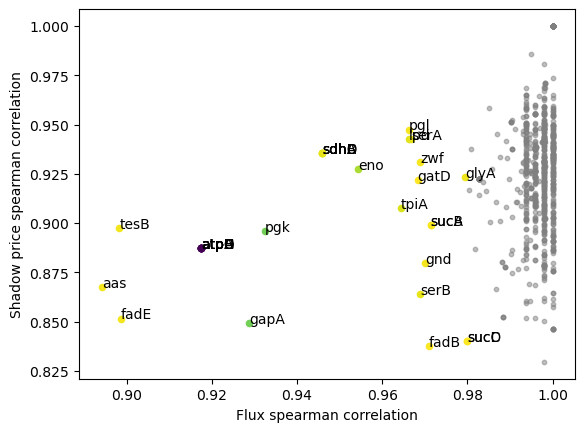

In [286]:
fig, ax = plt.subplots(1)
kind = 'spearman'
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    y = row[f'Shadow price {kind} correlation']
    if (x < 0.98) and (y):
        ax.scatter(x,y, c = row['Normalized growth rate'], vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'Shadow price {kind} correlation')
plt.xlabel(f'Flux {kind} correlation')
# plt.ylim(0.5, 0.7)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

# PCA

In [287]:
fluxes_df = pd.DataFrame(fluxes_dict)

In [288]:
nz_fluxes = fluxes_df.loc[~(fluxes_df==0).all(axis =1), :].T

In [289]:
Z_fluxes = (nz_fluxes - nz_fluxes.mean(axis=0))/(nz_fluxes.std(axis=0))

In [290]:
Z_fluxes = Z_fluxes.loc[:,nz_fluxes.std(axis=0)>1e-4]

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_37813/2129698872.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(t[:,0], t[:,1], cmap = 'jet')


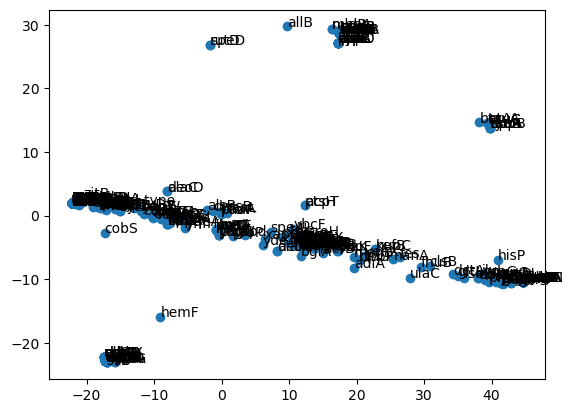

In [291]:
pca = PCA(n_components=2)
t = pca.fit_transform(Z_fluxes.T)
# clusterer = hdbscan.HDBSCAN()
# clusterer.fit(t)
fig, ax = plt.subplots(1)
ax.scatter(t[:,0], t[:,1], cmap = 'jet')
for i in range(len(t)):
    tx, ty = t[i, 0], t[i, 1]
    ax.annotate(gene_name_dict[Z_fluxes.index[i]], (tx, ty))
# print(len(np.unique(clustering.labels_)))

# Part 3

In [26]:
folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-SINTEF/UNIL/leakage/data/gene_KO_data')

In [27]:
neg_zscore = pd.read_csv(folder/'zscore_neg.tsv', sep = '\t', header=None)
pos_zscore = pd.read_csv(folder/'zscore_pos.tsv', sep = '\t', header=None)

In [28]:
zscores = pd.concat([neg_zscore, pos_zscore])

In [29]:
met_info = pd.read_excel(folder / 'metabolites.xlsx', sheet_name='Table EV1B')
met_info = met_info.iloc[1:,:4]

In [30]:
sample_info = pd.read_excel(folder / 'sample_id_zscore.xlsx', header = None)

In [31]:
zscores.columns = [x[0] for x in sample_info.values]

In [32]:
zscores

,aaeA,aaeB,aaeR,aaeX,aas,aat,abgA,abgB,abgR,abgT,...,zntR,znuA,znuB,znuC,zraP,zraR,zraS,zupT,zur,zwf
0,-0.4309,-1.8696,1.3402,0.2608,1.1950,-1.7969,-0.3466,0.8234,1.2770,0.5425,...,-1.0648,-0.2527,-0.8495,0.3368,0.0593,-0.0979,-0.3053,-0.0034,1.0841,0.1159
1,-0.1195,1.1863,-0.8219,-0.5211,0.2000,-1.5457,0.1708,0.8783,-0.2916,0.1869,...,-1.9948,0.5919,-1.2940,1.2607,1.2293,-3.1056,-2.4780,0.6874,-0.0932,-1.4013
2,-0.6621,1.7171,1.0256,0.0221,-0.4579,0.0185,0.4809,1.4925,0.5046,1.5039,...,-0.0292,0.4508,-3.3792,-0.9583,1.9758,-0.6508,-1.5141,2.3613,-2.3623,-0.4001
3,0.9284,0.3849,2.0786,-0.8930,0.8433,1.0175,0.7412,2.3298,-1.5026,0.5465,...,-0.9706,-0.4438,1.6652,-0.3749,0.3902,-0.5611,0.6083,0.0866,1.0464,0.3279
4,-0.6906,0.7550,-0.5455,0.4659,0.5156,-0.4498,0.5548,-0.8948,2.7675,0.6735,...,-0.1305,0.4575,-0.4649,-0.3647,-0.6224,0.0854,1.9919,0.2752,0.6782,0.3230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4360,0.6590,0.5567,0.7849,-0.4692,-1.0463,0.4669,0.5400,-0.6147,-0.5576,0.2206,...,-0.8172,-0.2027,-0.5120,0.7726,-0.7232,0.0849,1.9980,1.9671,-0.4920,1.3085
4361,-0.5588,0.2720,0.6939,0.4877,0.8092,0.2130,-0.3847,-0.3745,1.1807,-0.3879,...,0.8158,-0.4454,1.8465,-0.0894,0.8700,-1.1887,-1.6396,-1.5105,-0.5349,-0.2605
4362,-0.6122,0.0657,1.0083,0.9786,1.1222,-0.2939,0.5957,0.0391,2.2583,-0.0183,...,-3.1646,-0.2328,0.8116,0.0146,-0.2510,0.5481,-1.2467,0.9567,-0.7773,0.0695
4363,-1.5578,1.5634,-1.6051,0.4504,0.2041,-1.2855,0.7178,-0.6646,1.8836,0.3146,...,-2.6431,0.0096,-1.0767,0.4105,0.9191,-0.0470,-1.4584,-0.4606,-0.3933,-0.4982


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_37813/191682773.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(t[:,0], t[:,1], cmap = 'jet')


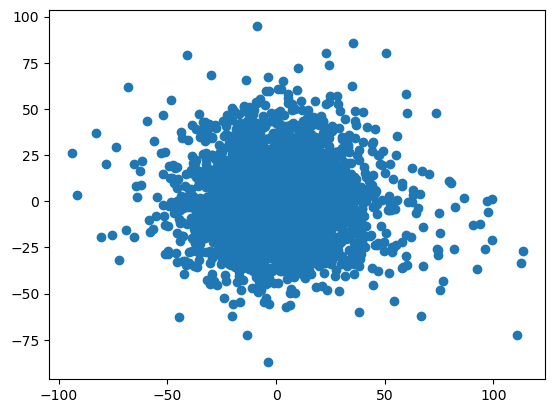

In [33]:
pca = PCA(n_components=2)
t = pca.fit_transform(zscores.T)
# clusterer = hdbscan.HDBSCAN()
# clusterer.fit(t)
fig, ax = plt.subplots(1)
ax.scatter(t[:,0], t[:,1], cmap = 'jet')
# for i in range(len(t)):
#     tx, ty = t[i, 0], t[i, 1]
#     ax.annotate(gene_name_dict[Z_fluxes.index[i]], (tx, ty))
# print(len(np.unique(clustering.labels_)))

In [325]:
n_changes = (zscores.abs() > 3).sum().sort_values(ascending = False) # 2.58 should be less than 1%

In [360]:
n_changes['lacA']

7

In [327]:
n_changes.head(30)

glcB    1231
nuoA    1200
talA    1054
rpmG    1044
msrA     880
nuoN     856
uhpA     830
rcsC     824
tap      791
cpxR     770
kdpD     747
rstB     739
purR     733
pfkA     719
cheY     701
yafY     686
ompR     680
ackA     677
appC     675
gltA     674
rpoN     670
rcsB     665
rssB     664
cysH     663
uhpB     659
wcaA     652
rnt      635
yacL     618
panC     601
dkgA     595
dtype: int64

In [328]:
bc = np.bincount(n_changes)

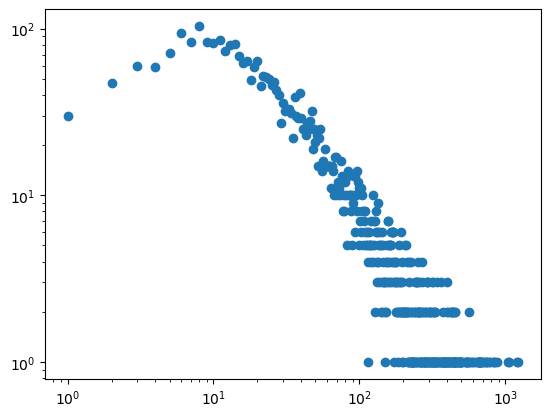

In [329]:
plt.scatter(np.arange(len(bc)), bc)
plt.xscale('log')
plt.yscale('log')

(array([2.635e+03, 5.700e+02, 2.560e+02, 1.140e+02, 8.000e+01, 4.400e+01,
        3.500e+01, 2.800e+01, 1.000e+01, 7.000e+00, 1.100e+01, 5.000e+00,
        4.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([   0.  ,   61.55,  123.1 ,  184.65,  246.2 ,  307.75,  369.3 ,
         430.85,  492.4 ,  553.95,  615.5 ,  677.05,  738.6 ,  800.15,
         861.7 ,  923.25,  984.8 , 1046.35, 1107.9 , 1169.45, 1231.  ]),
 <BarContainer object of 20 artists>)

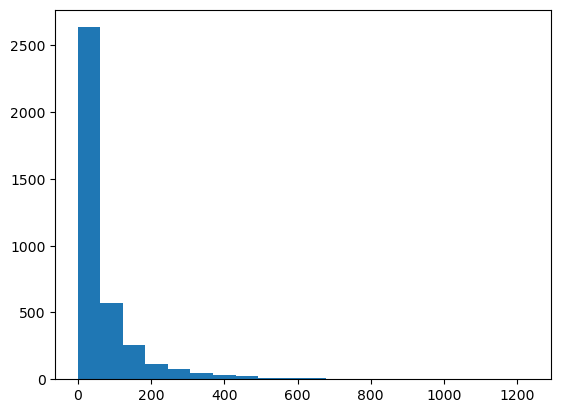

In [330]:
plt.hist(n_changes, bins = 20)

# Plot N changes in metabolite values vs correlation

In [331]:
# with model:
#     model.genes.get_by_id('b1136').knock_out()
#     print(model.optimize())

acnB 0.9938331478940564 341
dctA 0.9938418997456867 148
sucB 0.9713468827411136 213
sucA 0.9713468827411136 147
tolC 0.9938331506664351 103
ptsI 0.9867280021178424 170
ptsH 0.9901464857672201 197
glyA 0.9794774179031629 133
purT 0.9917090696272871 107
fadB 0.9709005260661658 124
cyoD 0.9901611667526096 364
cyoC 0.9901611667526096 405
cyoA 0.9901611667526096 142
cyoB 0.9901611667526096 133
apaH 0.9938329129431014 253
speE 0.9917236455835513 182
dcd 0.9938355273104947 203
speA 0.9938419017661697 116
fes 0.9938418782442171 254
purN 0.9924882911487637 442
lipA 0.9905715733802523 126
fecD 0.9938310489687466 106
fhuA 0.9938418870188782 225
gnd 0.970034592646516 156
maeB 0.9938372712430633 228
frdA 0.9949357261711474 430
frdB 0.9949357261711474 229
frdC 0.9949357261711474 212
frdD 0.9949357261711474 169
aroP 0.9938416777798338 360
ugpE 0.9938416680373089 130
ugpB 0.9938416680373089 155
nuoA 0.9827881878654324 1200
nuoL 0.9827881878654324 435
nuoM 0.9827881878654324 377
nuoB 0.9827881878654324

(0.95, 1.0)

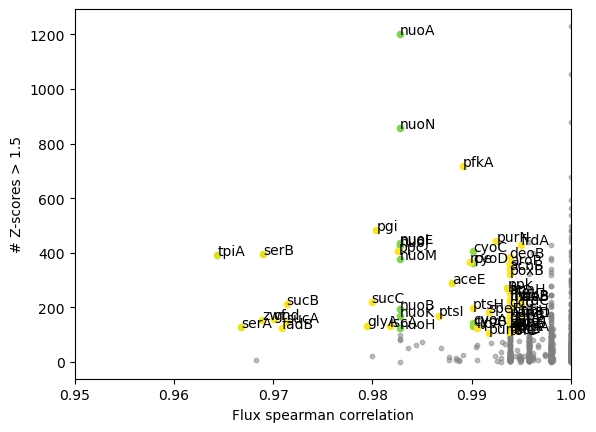

In [332]:
fig, ax = plt.subplots(1)
kind = 'spearman'
j = 0
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    try:
        y = n_changes[row["Gene name"]]
    except KeyError:
        # print(i, row["Gene name"])
        continue
    else:
        j+=1
        # print(i, row["Gene name"], y)
    if ((x < 0.995) and (y> 100)):
        ax.scatter(x,y, c = row['Normalized growth rate'],
                   vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
        print(row['Gene name'], x, y)
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'# Z-scores > 1.5')
plt.xlabel(f'Flux {kind} correlation')
# plt.ylim(0.5, 0.7)
plt.xlim(0.95, 1)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

adhE 1.0 498
sucB 0.9713468827411136 213
ackA 1.0 677
dkgA 1.0 595
glcB 1.0 1231
msrA 1.0 880
uxuA 0.9999975857282267 538
fumC 1.0 482
nuoA 0.9827881878654324 1200
nuoL 0.9827881878654324 435
nuoM 0.9827881878654324 377
nuoF 0.9827881878654324 431
nuoJ 0.9827881878654324 423
nuoN 0.9827881878654324 856
sdhD 0.9458400633265219 249
sdhB 0.9458400633265219 265
sdhC 0.9458400633265219 218
sucC 0.9799322611301347 220
aceE 0.9880648461311691 290
talA 1.0 1054
pfkA 0.9890987246940216 719
pgi 0.9804133123745608 483
tktB 1.0 565
tpiA 0.9643595424149589 392
ppc 0.9826321941403513 407
serB 0.9689775082458669 394
rpe 0.9898607461780362 366


Text(0.5, 0, 'Flux spearman correlation')

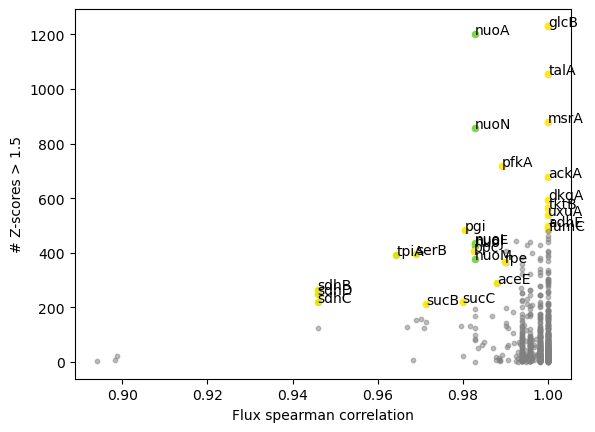

In [336]:
fig, ax = plt.subplots(1)
kind = 'spearman'
j = 0
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    try:
        y = n_changes[row["Gene name"]]
    except KeyError:
        # print(i, row["Gene name"])
        continue
    else:
        j+=1
        # print(i, row["Gene name"], y)
    if ((x < 0.99) and (y> 200)) or (y > 480):
        ax.scatter(x,y, c = row['Normalized growth rate'],
                   vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
        print(row['Gene name'], x, y)
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'# Z-scores > 1.5')
plt.xlabel(f'Flux {kind} correlation')
# plt.ylim(0.5, 0.7)
# plt.xlim(0.9, 1)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

# Notes
- glcB: Anaplerotic reaction in TCA from glyoxylate to malate
- dld: lactate to pyruvate
- talA: PPP (interesting!)
- nuoA: Electron transport chain
- fadB: degradation of fatty acids via the β-oxidation cycle
- cyoD: cytochrome electron transport chain
- ackA: acetate to acetyl-phosphate,  propionyl-CoA metabolism
- pfkA, 6-phosphofructokinase I;, glycolysis
- tktB: transketolase, PPP
- rpmG: ribosomal subunit
- msrA: methionine sulfoxide reductases, repairs oxidized methionine residues on proteins
- tap: chemotaxis
- purR: Regulatory gene, PurR dimer controls several genes involved in purine nucleotide biosynthesis and its own synthesis
- uhpA: UhpBA two-component signal transduction system (TCS) forms part of the E. coli Uhp system which is responsible for sensing and transport of the metabolic intermediate, glucose-6-phosphate.
- pldA: Outer membrane somethin
- glk: GLucose to glucose 6-phosphate
- pgi:
- sdhB: succinate:quinone oxidoreductase
- tpiA: D-glyceraldehyde 3-phosphate ⇄ glycerone phosphate
- frdA: Fumarate reductase, anaerobic respiration
- adhE: aldehyde/alcohol dehydrogenase AdhE
- dkgA: methylglyoxal reductase DkgA
# Other comments:
- eno: Essential
- rcsC: Regulator/signalling
- cysH: sulfate reduction, 3'-Phospho-adenylylsulfate reductase (CysH) is involved in the assimilation of sulfate and catalyzes the reduction of 3'-phospho-adenylylsulfate (PAPS) to sulfite and PAP. As a consequence of this and a subsequent reaction, the adenylate removed from the cell at the initiation of the cysteine biosynthetic pathway is returned as AMP
- ppc: Essential in MM according to ecocyc
- glyA: Essential


# Plot changes in shadow prices of measurable metabolites

In [373]:
#,'glcB',  'pfkA', 'tktB',, 'dld''talA',
# selected_genes = ['pgi',  'nuoA', 'fadB', 'cyoD', 'ackA', 'rpmG', 'msrA', 'pldA', 'glk', 'tpiA', 'sucB', 'sdhB', 'adhE', 'frdA', 'fumC', 'zwf', 'rpe', 'aceE', 'lacA']
selected_genes = ['nuoA', 'pgi', 'cyoD', 'tpiA', 'sucB', 'sdhB', 'rpmG', 'zwf', 'rpe', 'aceE', 'lacA']
name_gene_dict = {name:gene for gene, name in gene_name_dict.items()}

In [374]:
selected_gene_ids = [name_gene_dict[x] for x in selected_genes if name_gene_dict.get(x)]

In [375]:
measureable_mets = ['ala__L','arg__L','asn__L','ala_B','citr__L','4abut','glu__L','gln__L','gly__L','his__L','hmcr','ile__L',
'Lkynr','leu__L','lys__L','met__L','orn__L','phe__L','Lpipecol','pro__L','ser__L','taur','thr__L','4hpro_LT','trp__L','tyr__L','val__L','accoa','cit','icit','akg','succoa','succ','mal__L','gccoa','acon_T','g6p','f6p','pep','pyr','lac__L']

In [376]:
selected_gene_ids += ['WT']

In [377]:
data = []
met_ids = [f'{x}_c' for x in measureable_mets if f'{x}_c' in shadow_price_dict['WT'].index]

for gene in selected_gene_ids:
    try:
        sp = shadow_price_dict[gene][met_ids].values
    except KeyError:
        continue
    else:
        if sp is not None:
            data.append([gene, gene_name_dict[gene]]+list(sp))

In [378]:
sp_df = pd.DataFrame(data, columns = ['Gene', 'Gene name']+[x[:-2] for x in met_ids])
value_cols = [x[:-2] for x in met_ids]

In [379]:
Z_sp_df = (sp_df[value_cols] - sp_df[value_cols].mean(axis = 0))/sp_df[value_cols].std(axis = 0)
Z_sp_df['Gene name'] = sp_df['Gene name']

In [380]:
colors = sns.color_palette('tab20')

Text(0.5, 0, 'Z-score')

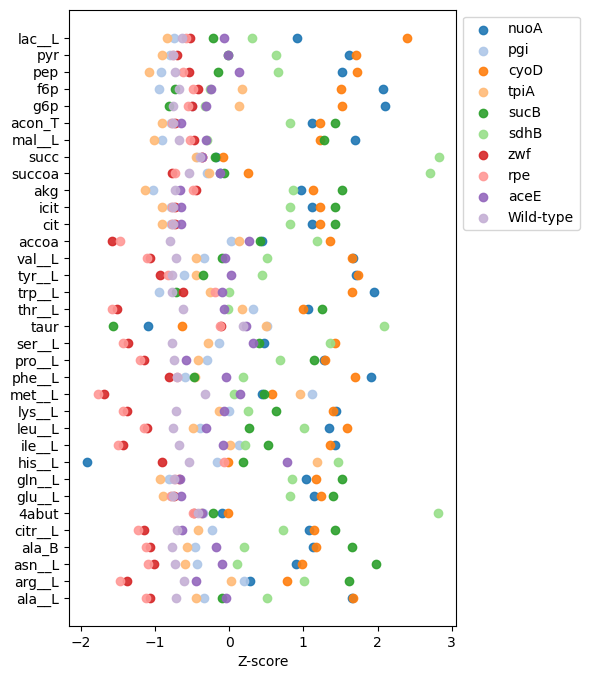

In [381]:
fig, ax = plt.subplots(1, figsize = (5,8))
x = np.arange(len(met_ids))
for i, row in Z_sp_df.iterrows():
    y = row[sp_df.columns[2:]]
    ax.scatter(x = y, y = x, label = row['Gene name'], color = colors[i], alpha = 0.9)
# plt.yscale('log')
# plt.xticks
plt.legend(bbox_to_anchor = (1, 1))
ax.set_yticks(x)
ax.set_yticklabels(value_cols)
plt.xlabel('Z-score')

sucB 0.9713468827411136 213
cyoD 0.9901611667526096 364
nuoA 0.9827881878654324 1200
zwf 0.9688871609321684 155
sdhB 0.9458400633265219 265
aceE 0.9880648461311691 290
pgi 0.9804133123745608 483
tpiA 0.9643595424149589 392
rpe 0.9898607461780362 366


(0.0, 1200.0)

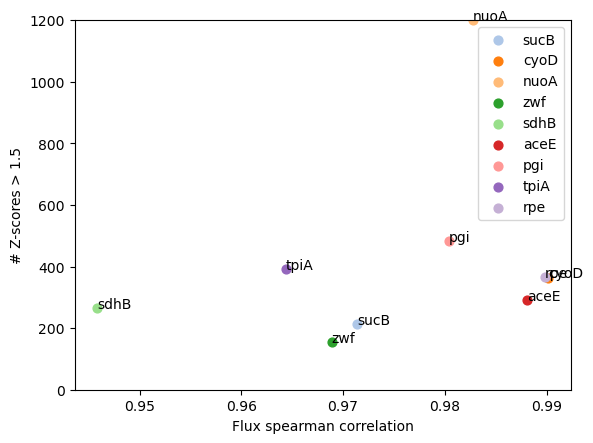

In [390]:
fig, ax = plt.subplots(1)
kind = 'spearman'
j = 0
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    if not row["Gene name"] in selected_genes:
        continue
    try:
        y = n_changes[row["Gene name"]]
    except KeyError:
        # print(i, row["Gene name"])
        continue
    else:
        j+=1
        # print(i, row["Gene name"], y)
   
    ax.scatter(x,y,color = colors[j], #row['Normalized growth rate'],
               s = 40, label = row['Gene name'])
    ax.annotate(row['Gene name'], (x, y))
    print(row['Gene name'], x, y)
        
plt.legend() 
plt.ylabel(f'# Z-scores > 1.5')
plt.xlabel(f'Flux {kind} correlation')
plt.ylim(0, 1200)

# Final selection

In [ ]:
final_selection = ['nuoA', 'pgi', 'cyoD', 'tpiA', 'sucB', 'sdhB', 'rpmG', 'zwf', 'rpe', 'aceE', 'lacA']
for gene_name in final_selection:
    

Text(0.5, 0, 'Z-score')

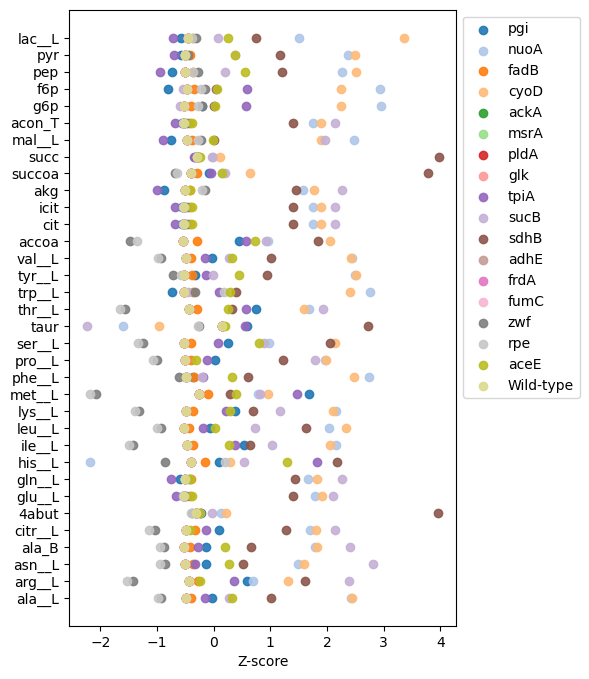

In [370]:
#moment iJO1366
# raise ValueError

fig, ax = plt.subplots(1, figsize = (5,8))
x = np.arange(len(met_ids))
for i, row in Z_sp_df.iterrows():
    y = row[sp_df.columns[2:]]
    ax.scatter(x = y, y = x, label = row['Gene name'], color = colors[i], alpha = 0.9)
# plt.yscale('log')
# plt.xticks
plt.legend(bbox_to_anchor = (1, 1))
ax.set_yticks(x)
ax.set_yticklabels(value_cols)
plt.xlabel('Z-score')

Text(0.5, 0, 'Z-score')

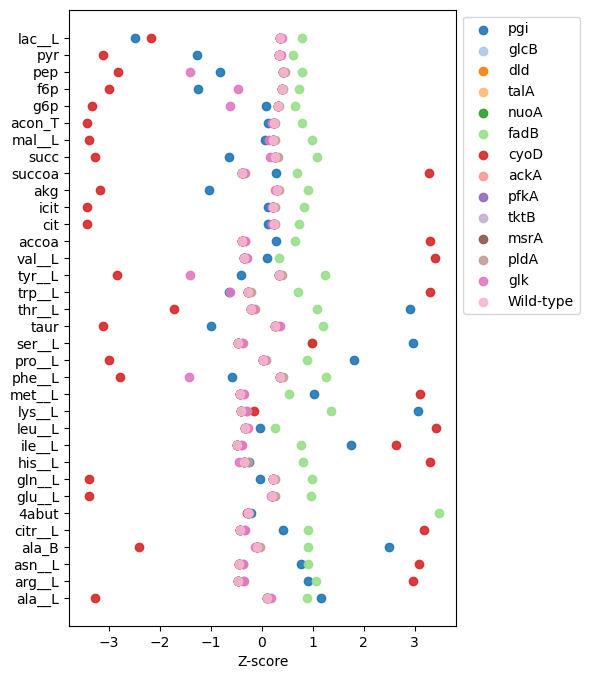

In [49]:
# iJO1366 galactose
fig, ax = plt.subplots(1, figsize = (5,8))
x = np.arange(len(met_ids))
for i, row in Z_sp_df.iterrows():
    y = row[sp_df.columns[2:]]
    ax.scatter(x = y, y = x, label = row['Gene name'], color = colors[i], alpha = 0.9)
# plt.yscale('log')
# plt.xticks
plt.legend(bbox_to_anchor = (1, 1))
ax.set_yticks(x)
ax.set_yticklabels(value_cols)
plt.xlabel('Z-score')

In [50]:
x = met_ids[0]
x in shadow_price_dict[gene].index

True

In [51]:
shadow_price_dict[gene][met_ids].values

array([-0.00913969, -0.12142808, -0.05517314, -0.01829299, -0.11093396,
       -0.02981857, -0.01983654, -0.0257286 , -0.17393865, -0.09831303,
       -0.22792005, -0.06360788, -0.30144912, -0.05766309, -0.03208797,
       -0.06224708, -0.00652646, -0.04369603, -0.21621397, -0.05808207,
       -0.0900308 , -0.79774319, -0.01752965, -0.01945205, -0.01643292,
       -0.80866189, -0.01293993, -0.01335135, -0.01849085, -0.01878618,
       -0.01888271, -0.0104263 , -0.00393846, -0.00549228])